In [1]:
import os
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
from functools import reduce
import time
import pandas as pd
import numpy as np
from PIL import Image
import random
import cv2

#  use gpu if available

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device('cpu')
print(device)

cuda


In [2]:
### BOUNDING BOX PREPROCESS
root = 'data'
folder = 'train'
class RacoonDatasetBoxes(object):
    def __init__(self, root, folder, apply_aug):
        self.root = root
        self.folder = folder
        self.apply_aug = apply_aug
        self.imgs = list(sorted(os.listdir(os.path.join(root, self.folder))))
        self.masks = pd.read_csv('train_labels_full.csv', sep=';').set_index('filename').sort_index()
    def __getitem__(self, idx):
        seed = np.random.randint(2147483647)
        
        img_path = os.path.join(self.root, self.folder, self.imgs[idx])
        mask_data = self.masks[self.masks.index==self.imgs[idx]]
        img_pil = Image.open(img_path).convert("RGB")
        width, height = img_pil.size
        
        #process image
        img = np.resize(np.array(img_pil),(height, width, 3))
        img = torch.from_numpy(img).permute(2, 0, 1)
        transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((572,572)),
            transforms.ToTensor(),
        ])
        img = transform(img)
        
        #process label
        label = torch.Tensor(height, width).fill_(0.0)
        for j in mask_data[['xmin', 'ymin', 'xmax', 'ymax']].values:
            x_min, y_min, x_max, y_max = j
            for i in range(y_min, y_max):
                label[i][x_min: x_max].fill_(1.0)
        label = label.view(height, width)
        transform_l = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((403,403)),
            transforms.ToTensor(),
        ])
        label = transform_l(label).view(403,403)
        
        # augmentations
        augmentation = transforms.Compose([
            transforms.ToPILImage(),
            transforms.RandomAffine(90, scale = (1,1.2), translate=(0.2,0.2)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(), 
            transforms.ToTensor(),
        ])
        if self.apply_aug == True:
            random.seed(seed)
            torch.manual_seed(seed)
            img = augmentation(img)
            random.seed(seed)
            torch.manual_seed(seed)
            label = augmentation(label).view(403,403).long()
        
        label = label.view(403,403).long()
        img = img.mul(255).long()
        return img, label 
    
    def __len__(self):
        return len(self.imgs)
    
class RacoonDatasetMasks(object):
    def __init__(self, root, folder, apply_aug):
        self.root = root
        self.folder = folder
        self.apply_aug = apply_aug
        self.imgs = list(sorted(os.listdir(os.path.join(root, self.folder))))
        self.masks = pd.read_csv('racoon_masks_full2.csv', sep=';').set_index('filename').sort_index()
    def __getitem__(self, idx):
        seed = np.random.randint(2147483647)
        
        img_path = os.path.join(self.root, self.folder, self.imgs[idx])
        mask_data = self.masks[self.masks.index==self.imgs[idx]]
        img_pil = Image.open(img_path).convert("RGB")
        width, height = img_pil.size
        
        #process image
        img = np.resize(np.array(img_pil, dtype=np.int32),(height, width, 3))
        img = torch.from_numpy(img).permute(2, 0, 1).to(torch.uint8)
        transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((572,572)),
            transforms.ToTensor(),
        ])
        img = transform(img)
 
        #process label
        label = np.zeros([height,width], dtype=np.int32)
        for j in mask_data[['x', 'y']].values:
            x, y = j
            x = x[1:-1]
            y = y[1:-1]
            x = [int(i) for i in x.split(',')]
            y = [int(i) for i in y.split(',')]
            area = np.column_stack([x, y])
            cv2.fillConvexPoly(label, area, (255, 255, 255))
        label = torch.from_numpy(label).to(torch.int32)
        transform_l = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((403,403)),
            transforms.ToTensor(),
        ])
        label = transform_l(label).view(403,403)/255
        
        # augmentations
        augmentation = transforms.Compose([
            transforms.ToPILImage(),
            transforms.RandomAffine(90, scale = (1,1.2), translate=(0.2,0.2)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(), 
            transforms.ToTensor(),
        ])
        if self.apply_aug == True:
            random.seed(seed)
            torch.manual_seed(seed)
            img = augmentation(img)
            random.seed(seed)
            torch.manual_seed(seed)
            label = augmentation(label).view(403,403).long()
        
        label = label.view(403,403).long()
        img = img.mul(255).long()
        return img, label 
    
    def __len__(self):
        return len(self.imgs)

### TEST IMAGE INPUT, MASK AND AUGMENTATIONS

..\torch\csrc\utils\tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.
..\aten\src\ATen\native\BinaryOps.cpp:81: UserWarning: Integer division of tensors using div or / is deprecated, and in a future release div will perform true division as in Python 3. Use true_divide or floor_divide (// in Python) instead.


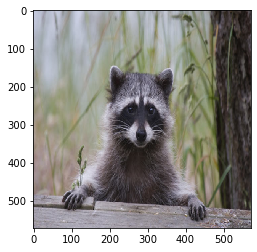

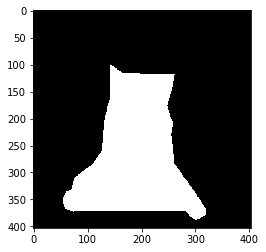

In [3]:
dataset = RacoonDatasetMasks(root, folder,  apply_aug = False)
img, label = dataset[0]
plt.imshow(img.permute(1, 2, 0))
plt.show()
plt.imshow(label, cmap='gray')
plt.show()

In [4]:
batch_size = 2
num_classes = 2

class UNET(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        # input img
        self.conv11 = nn.Conv2d(3, 64, 3, 1, 0)
        self.relu11 = nn.ReLU()
        #
        self.conv12 = nn.Conv2d(64, 64, 3, 1, 0)
        self.relu12 = nn.ReLU()
        # 2
        self.maxpool2 = nn.MaxPool2d(2, 2)
        #
        self.conv21 = nn.Conv2d(64, 128, 3, 1, 0)
        self.relu21 = nn.ReLU()    
        #
        self.conv22 = nn.Conv2d(128, 128, 3, 1, 0)
        self.relu22 = nn.ReLU()    
        # 3
        self.maxpool3 = nn.MaxPool2d(2, 2)
        #
        self.conv31 = nn.Conv2d(128, 256, 3, 1, 0)
        self.relu31 = nn.ReLU()    
        #
        self.conv32 = nn.Conv2d(256, 256, 3, 1, 0)
        self.relu32 = nn.ReLU()  
        # 4
        self.maxpool4 = nn.MaxPool2d(2, 2)
        #
        self.conv41 = nn.Conv2d(256, 512, 3, 1, 0)
        self.relu41 = nn.ReLU()    
        #
        self.conv42 = nn.Conv2d(512, 512, 3, 1, 0)
        self.relu42 = nn.ReLU()  
        # 5
        self.maxpool5 = nn.MaxPool2d(2, 2)
        #
        self.conv51 = nn.Conv2d(512, 1024, 3, 1, 0)
        self.relu51 = nn.ReLU()    
        #
        self.conv52 = nn.Conv2d(1024, 1024, 3, 1, 0)
        self.relu52 = nn.ReLU()  
        # 6
        self.upconv6 = nn.ConvTranspose2d(1024, 512, 3, 2, 0)
        #
        self.conv61 = nn.Conv2d(1024, 512, 3, 1, 0)
        self.relu61 = nn.ReLU()    
        #
        self.conv62 = nn.Conv2d(512, 512, 3, 1, 0)
        self.relu62 = nn.ReLU()
        # 7
        self.upconv7 = nn.ConvTranspose2d(512, 256, 3, 2, 0)
        #
        self.conv71 = nn.Conv2d(512, 256, 3, 1, 0)
        self.relu71 = nn.ReLU()    
        #
        self.conv72 = nn.Conv2d(256, 256, 3, 1, 0)
        self.relu72 = nn.ReLU()  
        # 8
        self.upconv8 = nn.ConvTranspose2d(256, 128, 3, 2, 0)
        #
        self.conv81 = nn.Conv2d(256, 128, 3, 1, 0)
        self.relu81 = nn.ReLU()    
        #
        self.conv82 = nn.Conv2d(128, 128, 3, 1, 0)
        self.relu82 = nn.ReLU()  
        # 9
        self.upconv9 = nn.ConvTranspose2d(128, 64, 3, 2, 0)
        #
        self.conv91 = nn.Conv2d(128, 64, 3, 1, 0)
        self.relu91 = nn.ReLU()    
        #
        self.conv92 = nn.Conv2d(64, 64, 3, 1, 0)
        self.relu92 = nn.ReLU()  
        # 10 conv 1x1
        self.conv_out = nn.Conv2d(64, num_classes, 1, 1, 0)
    def forward(self, x):
        x = x.view(-1, 3, 572, 572).float()
        x = self.relu11(self.conv11(x))
        x = self.relu12(self.conv12(x))
        x_568 = x.detach().clone()
        x_568 = x_568[:,:,75:75+407,75:75+407]
        # 2
        x = self.maxpool2(x)
        x = self.relu21(self.conv21(x))
        x = self.relu22(self.conv22(x))
        x_280 = x.detach().clone()
        x_280 = x_280[:,:,36:36+207,36:36+207]
        # 3
        x = self.maxpool3(x)
        x = self.relu31(self.conv31(x))
        x = self.relu32(self.conv32(x))
        x_136 = x.detach().clone()
        x_136 = x_136[:,:,9:9+107,9:9+107]
        # 4
        x = self.maxpool4(x)
        x = self.relu41(self.conv41(x))
        x = self.relu42(self.conv42(x))
        # copy and crop
        x_64 = x.detach().clone()
        x_64 = x_64[:,:,3:3+57,3:3+57]
        # 5
        x = self.maxpool5(x)
        x = self.relu51(self.conv51(x))
        x = self.relu52(self.conv52(x))
        # 6
        x = self.upconv6(x)
        x = torch.cat([x_64,x],1)
        x = self.relu61(self.conv61(x))
        x = self.relu62(self.conv62(x))
        # 7
        x = self.upconv7(x)
        x = torch.cat([x_136,x],1)
        x = self.relu71(self.conv71(x))
        x = self.relu72(self.conv72(x))
        # 8
        x = self.upconv8(x)
        x = torch.cat([x_280,x],1)
        x = self.relu81(self.conv81(x))
        x = self.relu82(self.conv82(x))
        # 9
        x = self.upconv9(x)
        x = torch.cat([x_568,x],1)
        x = self.relu91(self.conv91(x))
        x = self.relu92(self.conv92(x))
        # 10
        x = self.conv_out(x)
        return x

def weights_init(model):
    for (layer_name, weights) in model.named_parameters():
        if layer_name.find('conv') == 0 and len(weights.data.size())==4:
            N = weights.data.size()[1]*9
            std = (2/N)**(0.5)
            if layer_name == 'conv11.weight':
                nn.init.normal_(weights.data, 0.0, 0.06)
            else:
                nn.init.normal_(weights.data, 0.0, std)
    return print('Initialized')

#CREATE MODELS
model = UNET().to(device)
weights_init(model)


# Set optimizer and criterion
optimizer = optim.Adam(model.parameters(), lr=0.0002, betas=(0.95, 0.9999))

class_weights = torch.FloatTensor([1.4257, 3.3490]).to(device)
criterion = nn.CrossEntropyLoss(weight = class_weights)
    
def pytorch_count_params(model):
# count number trainable parameters in a pytorch model
    total_params = sum(reduce( lambda a, b: a*b, x.size()) for x in model.parameters())
    return total_params
print(model)
print('MODEL PARAMS: ',pytorch_count_params(model))

Initialized
UNET(
  (conv11): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
  (relu11): ReLU()
  (conv12): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (relu12): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv21): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (relu21): ReLU()
  (conv22): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (relu22): ReLU()
  (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv31): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (relu31): ReLU()
  (conv32): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
  (relu32): ReLU()
  (maxpool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv41): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
  (relu41): ReLU()
  (conv42): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1))
  (relu42): ReLU()
  (maxpool5): MaxPool2d(kernel_size=2, stride=2, padding=

In [ ]:
## load sets
train_loader = torch.utils.data.DataLoader(
    dataset, batch_size = batch_size, shuffle=True, num_workers=0
)
sf = nn.Softmax(1)

epochs = 800
for epoch in range(epochs):
    running_loss = 0.0
    accuracy = 0.0
    since = time.time()
    model.train()
    for i, (img, label) in enumerate(train_loader):
        model.to(device)
        img = img.to(device)
        label = label.to(device)

        optimizer.zero_grad()
        output = model(img)
        
        loss = criterion(output, label)
        loss.backward()
        
        optimizer.step() 
        print(i, end="\r")
        running_loss += loss.item()
        accuracy += torch.round(sf(output.detach())).view(-1,2,403,403)[:,1].eq(label).float().mean().item()/len(train_loader)

    ###eval  
    if epoch%10 == 0:
        model.eval()
        model.to('cpu')
        img, label = dataset[0]
        pred = sf(model(img).detach())
        mask = torch.round(pred)
        acc = mask.view(2,403,403)[1].eq(label).float().mean().item()
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16,8))
        ax1.imshow(img.permute(1, 2, 0))
        ax2.imshow(pred.view(2,403,403)[1], cmap='gray')
        ax3.imshow(mask.view(2,403,403)[1], cmap='gray')
        plt.show()
        print('ACCURACY: ', acc)

    time_elapsed = time.time() - since
    print("epoch : {}/{}, loss = {:.6f}, Accuracy = {:.6f},  time_elapsed: {:.2f}s".format\
          (epoch + 1, epochs, loss, accuracy, time_elapsed))

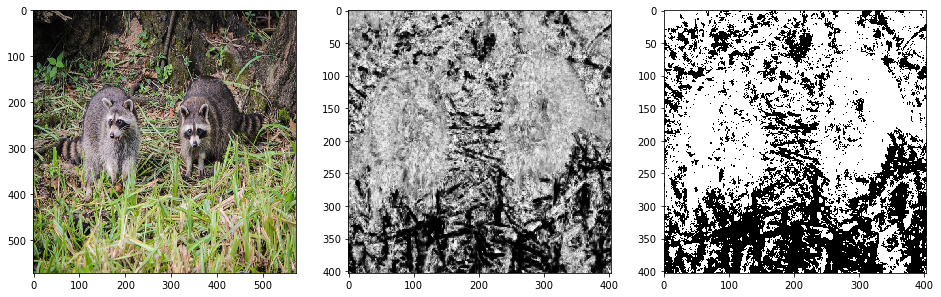

ACCURACY:  0.4962594509124756


In [10]:
model.eval()
model.to('cpu')
folder = 'train'
dataset = RacoonDatasetMasks('data',folder, apply_aug = False)
img, label = dataset[20]
sf = nn.Softmax(1)
pred = sf(model(img).detach())
mask = torch.round(pred)
accuracy = mask.view(2,403,403)[1].eq(label).float().mean().item()

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16,8))
ax1.imshow(img.permute(1, 2, 0))
ax2.imshow(pred.view(2,403,403)[1], cmap='gray')
ax3.imshow(mask.view(2,403,403)[1], cmap='gray')
plt.show()
print('ACCURACY: ', accuracy)